In [84]:
import pandas as pd
import numpy as np
import gdxpds
import os

south_share = 0.65; #65
freq = '125Min'; #125
variance = 0.35; #0.35

In [85]:
# scale renewable profiles

res = pd.read_excel('in_48h.xlsx', sheet_name = 'timeseries')
res = res.iloc[2:27, 1:9]
res.columns = ['int', 'load_north', 'load_south', 'int_2', 'Wind_north', 'Solar_north', 'Wind_south', 'Solar_south']
res.index = pd.to_timedelta(res.index-2, 'hours')
for c in res.columns:
    res[c] = res[c].astype(float, errors = 'raise')
    
renewables = res.resample(freq).mean().round(2)

combined = renewables[['load_north', 'load_south', 'Wind_north', 'Solar_north', 'Wind_south', 'Solar_south']]

#load profile

load = pd.read_pickle('2015-2020_load_generation.pkl')
df = load['DE']
df = df.loc[df.index.year == 2020]
load_curve = df.groupby(df.index.hour).mean()

load_curve.index = pd.to_timedelta(load_curve.index, 'hours')
series = load_curve.resample(freq).mean()

#generic load profile
#series = pd.Series(np.ones(series.shape), series.index, name=series.name) * round(series.mean(),-3)

load = pd.DataFrame(data = series.values, index = series.index, columns = ['total load'])

np.random.seed([3,14])
load['north'] = load['total load'] *((1-south_share) + np.random.uniform(-variance, variance, len(load)))

load['north'] = [max(0,i) for i in load['north']]

load['south'] = load['total load'] - load['north']
load = load.round(-1)


# --- SAVE LOAD DATA ---
load = load.reset_index()[['north','south']]
load.index = load.index.rename('t')
load.index = load.index+1
load.to_excel('load.xlsx')

load = load.stack().reset_index();
load.columns = ['t','n','value'];

data_ready_for_GAMS = { 'i_load': load }

gdx_file = '../Two node models/load.gdx'
gdx = gdxpds.to_gdx(data_ready_for_GAMS, gdx_file)



# --- SAVE RES DATA
north = renewables[['Wind_north', 'Solar_north']]
north.columns = ['wind', 'solar']
north.loc[:,'n'] = 'north'
north.loc[:,'t'] = range(1,len(north)+1)

south = renewables[['Wind_south', 'Solar_south']]
south.columns = ['wind', 'solar']
south.loc[:,'n'] = 'south'
south.loc[:,'t'] = range(1,len(north)+1)

re = north.append(south);
re = re.iloc[:, [3, 2, 0, 1]]
re = re.set_index(['t','n'])
re = re.unstack()
re.to_excel('avail.xlsx')

tmp = pd.DataFrame(re.stack().stack())
tmp.index.names = ['t','n','tec']
tmp = tmp.reset_index()
tmp = tmp.iloc[:, [0, 2, 1, 3]]
tmp = tmp.rename(columns = {0:'value'})

data_ready_for_GAMS = { 'i_avail': tmp }

gdx_file = '../Two node models/avail.gdx'
gdx = gdxpds.to_gdx(data_ready_for_GAMS, gdx_file)

C:\Users\a.eicke\Miniconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [86]:
#os.system(str('cmd /k "gams ../Two node models/nodal.gms"'))

In [87]:
load

,t,n,value
0,1,north,7980.0
1,1,south,36460.0
2,2,north,4280.0
3,2,south,40860.0
4,3,north,3820.0
5,3,south,48270.0
6,4,north,30240.0
7,4,south,29110.0
8,5,north,22380.0
9,5,south,40160.0


In [79]:
tmp

,t,tec,n,value
0,1,wind,north,0.43
1,1,solar,north,0.00
2,1,wind,south,0.31
3,1,solar,south,0.00
4,2,wind,north,0.24
5,2,solar,north,0.20
6,2,wind,south,0.16
7,2,solar,south,0.08
8,3,wind,north,0.20
9,3,solar,north,0.36


In [64]:
load.loc[load['n']=='north']['value'].std()

6418.124790324338

# OLD

,total load,north,south
0 days 00:00:00,44437.2,11167.1,33270.0
0 days 02:05:00,45137.8,10249.9,34887.9
0 days 04:10:00,52094.8,11510.4,40584.5
0 days 06:15:00,59340.7,20506.8,38833.8
0 days 08:20:00,62540.8,18902.5,43638.3
0 days 10:25:00,63040.3,24764.9,38275.5
0 days 12:30:00,60645.3,23616.7,37028.6
0 days 14:35:00,59380.1,14309.2,45070.9
0 days 16:40:00,60870.1,21832.1,39038.0
0 days 18:45:00,58055.3,16613.7,41441.6


In [29]:
new_frequency['south']  / new_frequency['total load']

0 days 00:00:00    0.748697
0 days 02:05:00    0.772920
0 days 04:10:00    0.779051
0 days 06:15:00    0.654421
0 days 08:20:00    0.697757
0 days 10:25:00    0.607159
0 days 12:30:00    0.610577
0 days 14:35:00    0.759024
0 days 16:40:00    0.641333
0 days 18:45:00    0.713830
0 days 20:50:00    0.790836
0 days 22:55:00    0.729500
Freq: 125T, dtype: float64

In [30]:
#RES data
res = pd.read_excel('in.xlsx', sheet_name = 'timeseries')
res = res.iloc[2:27, 5:9,]
res.index = pd.to_timedelta((res.index-2), 'hours')
res.columns = [['Wind_north', 'Solar_north', 'Wind_south', 'Solar_south']]

In [31]:
res

,Wind_north,Solar_north,Wind_south,Solar_south
0 days 00:00:00,0.485,0,0.33,0
0 days 01:00:00,0.305,0.06,0.22,0.01
0 days 02:00:00,0.195,0.315,0.135,0.235
0 days 03:00:00,0.22,0.31,0.115,0.205
0 days 04:00:00,0.18,0.09,0.14,0.07
0 days 05:00:00,0.125,0,0.13,0
0 days 06:00:00,0.06,0,0.08,0
0 days 07:00:00,0.105,0.015,0.085,0.02
0 days 08:00:00,0.17,0.19,0.16,0.295
0 days 09:00:00,0.22,0.32,0.21,0.45


In [243]:
res = res.resample(freq).mean().iloc[:-1,:]

In [244]:
new_frequency[['Wind_north', 'Solar_north', 'Wind_south', 'Solar_south']] = res

In [245]:
new_frequency

,total load,north,south,Wind_north,Solar_north,Wind_south,Solar_south
0 days 00:00:00,44774.2,14379.6,30394.6,0.430,0.000,0.315,0.000
0 days 01:30:00,43763.1,13789.9,29973.2,0.390,0.000,0.280,0.000
0 days 03:00:00,45137.8,14153.9,30983.9,0.345,0.000,0.220,0.000
0 days 04:30:00,49783.8,17161.9,32621.9,0.300,0.000,0.140,0.010
0 days 06:00:00,56330.0,18808.2,37521.7,0.235,0.065,0.090,0.135
0 days 07:30:00,60427.2,21544.9,38882.3,0.220,0.270,0.050,0.390
0 days 09:00:00,62540.8,22245.1,40295.7,0.215,0.405,0.075,0.470
0 days 10:30:00,63503.5,20230.8,43272.7,0.200,0.440,0.130,0.470
0 days 12:00:00,61904.6,21542.8,40361.8,0.180,0.380,0.145,0.325
0 days 13:30:00,60058.5,19811.9,40246.7,0.150,0.210,0.160,0.150


In [33]:
new_frequency.to_csv('12_load.csv')

<AxesSubplot:>

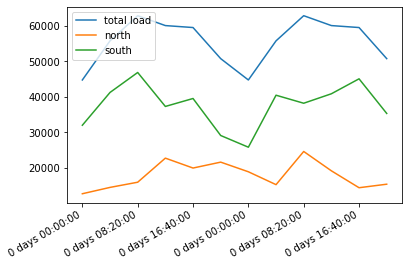

In [32]:
new_frequency.plot()

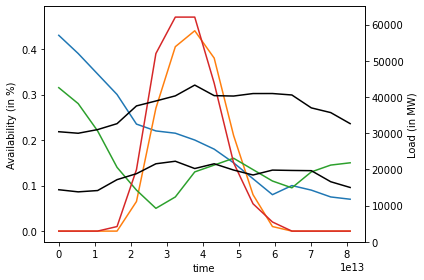

In [248]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data

fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('Availability (in %)')
ax1.plot(new_frequency.index, new_frequency[['Wind_north', 'Solar_north', 'Wind_south', 'Solar_south']])
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Load (in MW)')
ax2.plot(new_frequency.index, new_frequency[['north','south']], color = 'black')
ax2.tick_params(axis='y')
ax2.set_ylim([0, 65000])
#ax2.ylim[0,max(new_frequency['south'])+ 1000]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()